<a href="https://colab.research.google.com/github/crayrodrigues/Artificial-Intelligence/blob/main/Stocks_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this projecct, we will be using LSTM to predct the closing price of Apple Inc. Stocks. For that, we will be using the last 60 days stock price

In [1]:
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Import libraries 
import math 
import pandas_datareader as web 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM

plt.style.use("fivethirtyeight")

In [6]:
#Import Stock dataset
df = web.DataReader('AAPL', data_source = 'yahoo', start='2012-01-01', end='2022-10-03')

In [8]:
#Show data
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-20,158.080002,153.080002,153.399994,156.899994,107689800.0,156.899994
2022-09-21,158.740005,153.600006,157.339996,153.720001,101696800.0,153.720001
2022-09-22,154.470001,150.910004,152.380005,152.740005,86652500.0,152.740005
2022-09-23,151.470001,148.559998,151.190002,150.429993,95939200.0,150.429993
2022-09-26,153.770004,149.639999,149.660004,150.770004,93339400.0,150.770004
2022-09-27,154.720001,149.949997,152.740005,151.759995,84442700.0,151.759995
2022-09-28,150.639999,144.839996,147.639999,149.839996,146691400.0,149.839996
2022-09-29,146.720001,140.679993,146.100006,142.479996,128138200.0,142.479996
2022-09-30,143.100006,138.000000,141.279999,138.199997,124705400.0,138.199997


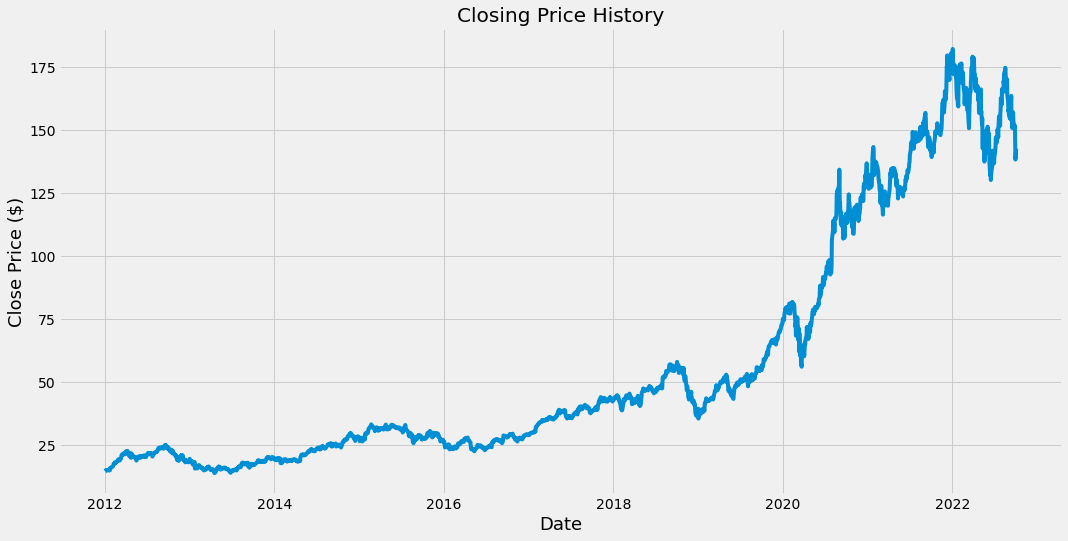

In [10]:
#Visualise closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
plt.show()

In [11]:
#Create dataframe with only the close columns. 
data = df.filter(['Close'])

#Convert to numpy array
dataset = data.values

#Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

#Split dataset into 80-20 
training_len = math.ceil(len(dataset)*.8)
train_data = scaled_data[:training_len, :]

#Split the data into x_train and y_train (x_train --> last 60 days stocks, y_train --> stock)
x_train=[]
y_train=[]
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i, 0])



In [13]:
#Convert x_train and y_train to numpy
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data for LSTM model (2D -> 3D [#samples, #timesteps, #features])
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 


In [16]:
#Build model 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [17]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
#Train model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2105/2105 [==============================] - 75s 33ms/step - loss: 3.5841e-04


In [19]:
#Create testing dataset 
test_data = scaled_data[training_len-60:, :]

#Split the data into x_test and y_test (x_test --> last 60 days stocks, y_test --> stock)
x_test=[]
y_test=dataset[training_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [20]:
#Convert to numpy
x_test = np.array(x_test)

In [21]:
#Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [22]:
#Get predictions for x_test
predictions = model.predict(x_test)

#inverse transform the data (unscale)
predictions = scaler.inverse_transform(predictions)

In [23]:
#Get RMSE results 
rmse = np.sqrt(np.mean(predictions - y_test)**2)

rmse


8.167725963204713

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


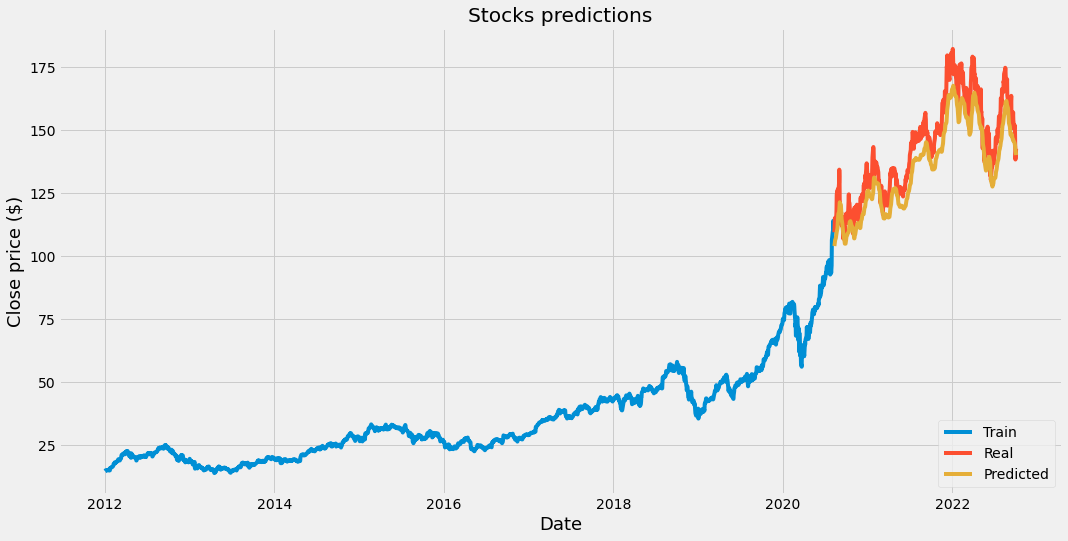

In [24]:
#Plot data
train = data[:training_len]
pred = data[training_len:]
pred["Predicted"] = predictions

#Visualise data
plt.figure(figsize=(16,8))
plt.title("Stocks predictions")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close price ($)", fontsize=18)
plt.plot(train['Close'])
plt.plot(pred[['Close', 'Predicted']])
plt.legend(['Train', 'Real', 'Predicted'], loc='lower right')
plt.show()